In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

"Machine learning tools"
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.decomposition import PCA
import pickle

from classification.datasets import Dataset
from classification.utils.plots import plot_specgram, show_confusion_matrix, plot_decision_boundaries
from classification.utils.utils import accuracy
from classification.utils.audio_student import AudioUtil, Feature_vector_DS

In [2]:
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))

birds
chainsaw
fire
handsaw
helicopter


In [3]:
fm_dir = "dataNN/feature_ma/" # where to save the features matrices
model_dir = "dataNN/model/" # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [4]:
"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=0.0)

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol

20

In [40]:
### TO RUN
"Random split of 70:30 between training and validation"
train_pct = 0.7

featveclen = len(myds["fire",0]) # number of items in a feature vector
nitems = len(myds) # number of sounds in the dataset
naudio = dataset.naudio # number of audio files in each class
nclass = dataset.nclass # number of classes
nlearn = round(naudio * train_pct) # number of sounds among naudio for training

data_aug_factor = 1
class_ids_aug = np.repeat(classnames, naudio*data_aug_factor)

"Compute the matrixed dataset, this takes some seconds, but you can then reload it by commenting this loop and decommenting the np.load below"
X = np.zeros((data_aug_factor*nclass*naudio, featveclen))
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio):
            featvec = myds[classname, idx]
            X[s*nclass*naudio+class_idx*naudio+idx,:] = featvec       
np.save(fm_dir+"feature_matrix_2D.npy", X)

# X = np.load(fm_dir+"feature_matrix_2D.npy")

"Labels"
y = class_ids_aug.copy()

print('Shape of the feature matrix : {}'.format(X.shape))
print('Number of labels : {}'.format(len(y)))

print('Remember the convention shown for the toy example, the feature vectors are arranged on the rows.')

Shape of the feature matrix : (200, 400)
Number of labels : 200
Remember the convention shown for the toy example, the feature vectors are arranged on the rows.


<font size=5 color=#009999> Augmentation data </font> <br>

In [62]:
import time

myds.data_aug = None # Ensure
myds.data_aug_factor = 1

### TO RUN
# myds.mod_data_aug(['add_bg'])
# myds.mod_data_aug(['echo'])
# myds.mod_data_aug(['noise'])
# myds.mod_data_aug(['scaling'])

myds.mod_data_aug(['echo','add_bg'])
y_aug = np.repeat(classnames, dataset.naudio*myds.data_aug_factor) # Labels

for i in range (10):
    print(i)
    cls_index = ["birds",i]
    sound = dataset.__getitem__(cls_index) 
    audio = AudioUtil.open(sound)
    AudioUtil.play(audio)
    time.sleep(5)
    

"Compute the matrixed dataset, this takes some seconds, but you can then reload it by commenting this loop and decommenting the np.load below"
X_aug = np.zeros((myds.data_aug_factor*nclass*naudio, featveclen))
for s in range(myds.data_aug_factor):
    for idx in range(dataset.naudio):
        for class_idx, classname in enumerate(classnames):
            featvec = myds[classname, idx]  
            X_aug[s*nclass*naudio+class_idx*naudio+idx,:] = featvec 
np.save(fm_dir+"feature_matrix_2D_aug.npy", X_aug)
print(len(X_aug))
#X_aug = np.load(fm_dir+"feature_matrix_2D_aug.npy")

print('Shape of the feature matrix : {}'.format(X_aug.shape))
print('Number of labels : {}'.format(len(y_aug)))

0
1
2
3
4
5
6
7
8
9
600
Shape of the feature matrix : (600, 400)
Number of labels : 600


Accuracy of KNN with fixed train/validation sets : 10.6%


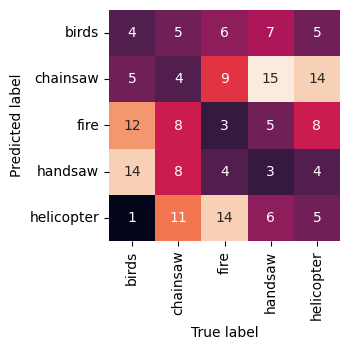

In [55]:
train_pct = 0.7
X_train, X_test, y_train, y_test = train_test_split(X_aug, y_aug, test_size=0.3, stratify=y_aug)

X_train_normalised = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
X_test_normalised = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)

#-------------------------

K = 15 # Number of neighbours for the KNN
model = KNeighborsClassifier(n_neighbors=K, weights='distance', algorithm='auto', metric='minkowski') #We explicitly write the default parameters of this KNN classifier once so that you know they exist and can be changed

model.fit(X_train_normalised,y_train)
prediction = model.predict(X_test_normalised)

accuracy_knn = accuracy(prediction , y_test)

print('Accuracy of KNN with fixed train/validation sets : {:.1f}%'.format(100*accuracy_knn))
show_confusion_matrix (prediction, y_test, classnames)

<font size=5 color=#009999> Simple KNN - jouet </font> <br>

Accuracy of KNN with fixed train/validation sets : 40.0%


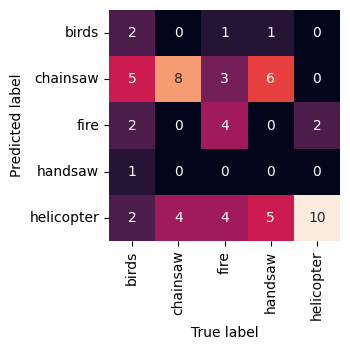

In [56]:
train_pct = 0.7
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

X_train_normalised = X_train / np.linalg.norm(X_train, axis=1, keepdims=True)
X_test_normalised = X_test / np.linalg.norm(X_test, axis=1, keepdims=True)

#-------------------------

K = 15 # Number of neighbours for the KNN
model = KNeighborsClassifier(n_neighbors=K, weights='distance', algorithm='auto', metric='minkowski') #We explicitly write the default parameters of this KNN classifier once so that you know they exist and can be changed

model.fit(X_train_normalised,y_train)
prediction = model.predict(X_test_normalised)

accuracy_knn = accuracy(prediction , y_test)

print('Accuracy of KNN with fixed train/validation sets : {:.1f}%'.format(100*accuracy_knn))
show_confusion_matrix (prediction, y_test, classnames)



Mean accuracy with 5-Fold CV: 43.6%
Std deviation in accuracy with 5-Fold CV: 8.7%


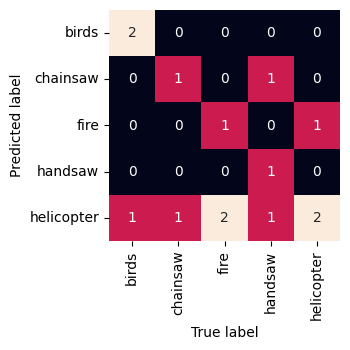

In [80]:
K = 15 # Number of neighbours for the KNN
model = KNeighborsClassifier(n_neighbors=K, weights='distance', algorithm='auto', metric='minkowski') #We explicitly write the default parameters of this KNN classifier once so that you know they exist and can be changed

n_splits = 10
kf = StratifiedKFold(n_splits=n_splits,shuffle=True)

accuracy_KNN = np.zeros((n_splits,))
for k, idx in enumerate(kf.split(X_train_normalised,y_train)):
  (idx_train, idx_test) = idx
  model.fit(X_train_normalised[idx_train], y_train[idx_train])
  prediction_KNN = model.predict(X_train_normalised[idx_test])
  accuracy_KNN[k] = accuracy(prediction_KNN, y_train[idx_test])

print('Mean accuracy with 5-Fold CV: {:.1f}%'.format(100*accuracy_KNN.mean()))
print('Std deviation in accuracy with 5-Fold CV: {:.1f}%'.format(100*accuracy_KNN.std()))
show_confusion_matrix(prediction_KNN, y_train[idx_test], classnames)


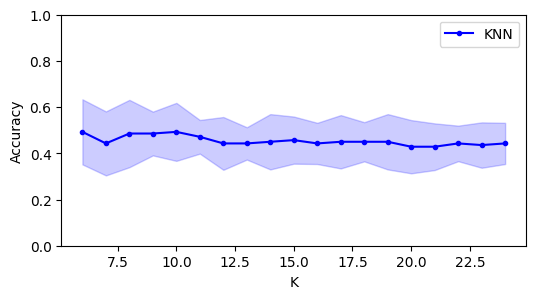

In [79]:
### TO RUN
Ks = np.arange(6,25, 1)
accuracies_knn = np.zeros((len(Ks), n_splits))
for i,K in enumerate(Ks):
    model_knn = KNeighborsClassifier(n_neighbors=K, weights='distance') 
    for k, idx in enumerate(kf.split(X_train,y_train)):
            (idx_learn, idx_val) = idx
            model_knn.fit(X_train[idx_learn], y_train[idx_learn])
            prediction_knn = model_knn.predict(X_train[idx_val])
            accuracies_knn[i,k] = accuracy(prediction_knn, y_train[idx_val])
means_knn = accuracies_knn.mean(axis=1)
stds_knn = accuracies_knn.std(axis=1)

"Plot"
plt.figure(figsize=(6,3))
plt.plot(Ks, means_knn, '.-b', label='KNN')
plt.fill_between(Ks,means_knn-stds_knn,means_knn+stds_knn,alpha=0.2,color='b')
plt.ylim(0,1)
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
#Save the trained model, eventually the pca.
#filename = 'model.pickle'
#pickle.dump(model, open(model_dir+filename, 'wb'))